金利曲線をモデリングするために、1987年にCharles R. NelsonとAndrew F. SiegelはNelson-Siegelモデルを提唱しました。特に、このモデルはゼロクーポンボンドのイールドカーブを表現するのに適しています。

Nelson-Siegelモデルは以下の式で表されます。

$$Y(t) = b_0 + b_1 * [(1 - \exp(-t/\tau)) / (t/\tau)] + b_2 * {[(1 - \exp(-t/\tau)) / (t/\tau)] - \exp(-t/\tau)}$$

ここで、

$Y(t)$ は満期までの時間 t のゼロクーポンボンドのイールドを表します。
$b_0$, $b_1$, $b_2$ はモデルのパラメータで、イールドカーブの水準、傾き(slope)、および曲率(curvature)を表します。
$\tau$ はスケーリングパラメータで、カーブの形状を調整します。
モデルの特徴は、これら3つの要素を使用して金利曲線を捉えることです。

水準・レベル（$b_0$）は、長期的なイールド（時間が無限大に近づくときのイールド）を反映します。
傾き（$b_1$）は短期と長期のイールドとの間のスプレッド（金利差）を表します。
曲率（$b_2$）は中期のイールドの動きを表します。
Nelson-Siegelモデルは金利モデルの基礎となっています。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.api import OLS
from pandas.tseries.offsets import DateOffset

import pandas_datareader.data as web
start="1949/5/16"


金利のデータをFREDから入手します。

10-Year Treasury Constant Maturity Rate (DGS10) daily  
5-Year Treasury Constant Maturity Rate (DGS5) daily  
1-Year Treasury Constant Maturity Rate (DGS1) daily  

モデルを簡単にするために、3つの満期の米国財務省債券のConstant Maturity Rate(CMR)を使います。ゼロカーブは使いません。また長期の金利なので対数を取ってみました。

In [2]:
ty10 = web.DataReader("DGS10", 'fred',start)#Population, Total for World
ty5 = web.DataReader("DGS5", 'fred',start)#Population, Total for World
ty1 = web.DataReader("DGS1", 'fred',start)#Population, Total for World
ty=pd.concat([ty1,ty5,ty10],axis=1).dropna()

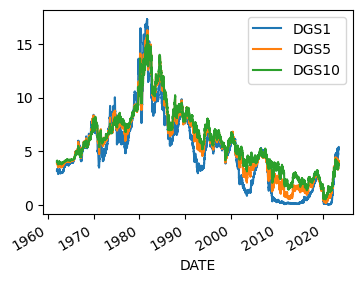

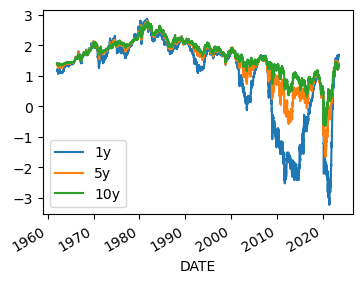

In [3]:
#swap.index = pd.to_datetime(swap.index)
#swap=swap.resample("M").last()
ty.plot(figsize=(4,3))
ty.columns=['1y','5y','10y']
plt.show()
lnty=np.log(ty)
lnty.plot(figsize=(4,3))
plt.show()

Nelson-Siegelモデルの米国債のイールドカーブを3つの満期のCMRから構築します。日足のデータが手に入るので、３つのCRMを水準、傾き、曲率の3つの変数で説明するモデルを最小二乗法を用いて求めます。つまり水準、傾き、曲率の係数は日々計算します。

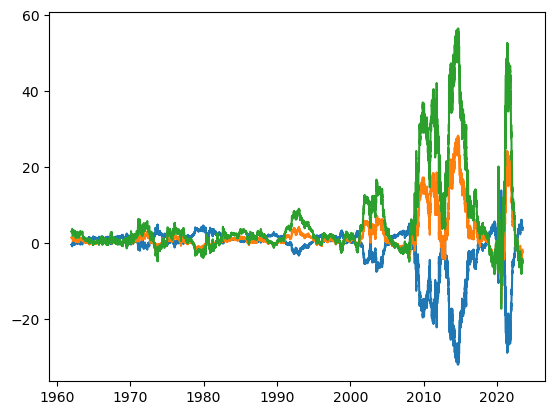

In [4]:
# Nelson-Siegel model shape functions
def ns_shape_0(t, lambda_):
    return np.ones_like(t)

def ns_shape_1(t, lambda_):
    return (1 - np.exp(-lambda_*t)) / (lambda_*t)

def ns_shape_2(t, lambda_):
    return ((1 - np.exp(-lambda_*t)) / (lambda_*t)) - np.exp(-lambda_*t)
t_values = np.array([1, 5, 10])

# Choose a value for the shape parameter lambda
lambda_ = 0.1
endog=lnty
# Perform the linear regression to estimate b0, b1, b2 for each time point
X=[]
for t in endog.index:
    # Calculate the values of the shape functions for each maturity
    shape_0_values = ns_shape_0(t_values, lambda_)
    shape_1_values = ns_shape_1(t_values, lambda_)
    shape_2_values = ns_shape_2(t_values, lambda_)

    # Create a DataFrame with the shape function values
    shape_df = pd.DataFrame({
        'shape_0': shape_0_values,
        'shape_1': shape_1_values,
        'shape_2': shape_2_values,
    }, index=['1y', '5y', '10y'])

    y = endog.loc[t, :]
    model = OLS(y, shape_df)
    results = model.fit()
    #estimated_params.loc[t,['b0', 'b1', 'b2']] = results.params.values
    X.append(results.params.values)

X=pd.DataFrame(X,index=endog.index,columns=['b0','b1','b2'])
plt.plot(X)
plt.show()

In [5]:
def forecastARIMA(nforecasts,X=X['b0'],order=(1,0,0)):
    endog=X.copy()
    da=[]
    fv=[]
    f = []
    f250=[]

    if not isinstance(endog.index, pd.PeriodIndex):
        endog.index = endog.index.to_period('D')  # ここでは日次データを仮定しています
    # Get the number of initial training observations
    nobs = len(endog)
    n_init_training = int(nobs * 0.1)
    nobs2=n_init_training
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    mod = ARIMA(training_endog, order=order)
    res = mod.fit(method='yule_walker')
    # Save initial forecast
    da.append(training_endog.index[-1])
    fv=res.fittedvalues.values.tolist()
    f.append(res.forecast(steps=nforecasts).values[-1])
    f250.append(res.forecast(steps=250).values[-1])
    #print(len(fv),fv)
    print('init',n_init_training)
    print('random walk rmse', training_endog.diff().var()**0.5)
    print('ar1 rmse        ',(np.mean(res.resid**2))**0.5,len(res.resid))

    # Step through the rest of the sample
    for t in range(n_init_training, nobs):
        # Update the results by appending the next observation
        updated_endog = endog.iloc[t-nobs2:t+1]
        mod = ARIMA(updated_endog,order=order)
        res = mod.fit(method='yule_walker')
        # Save the new set of forecasts
        da.append(updated_endog.index[-1])
        fv.append(res.fittedvalues.values[-1])
        f.append(res.forecast(steps=nforecasts).values[-1])
        f250.append(res.forecast(steps=250).values[-1])

    print('repeat',nobs)
    print('random walk rmse         ', endog.diff().var()**0.5)
    fv=pd.DataFrame(fv,index=X.index,columns=["fv"])
    print('ar1 rmse  in sample      ',(np.mean((fv.values.T-endog.values.T)**2)**0.5,len(res.resid))[0])

    fc=pd.DataFrame(f,index=X.index[-len(f):],columns=['fc'])
    
    tmp=pd.concat([fc,endog],axis=1).dropna()
    tmp.columns=['fc','ny']
    # ここでは日次データを仮定しています,
    print("out of sample forecast", np.mean((fc.iloc[:-1].T.values-endog.iloc[-len(fc)+1:].T.values)**2)**0.5)

    print('random walk rmse 250         ', endog.diff(250).var()**0.5)
    fc250=pd.DataFrame(f250,index=X.index[-len(f250):],columns=["fc250"])
    print("out of sample forecast",np.mean((fc250.iloc[:-1].T.values-endog.iloc[-len(fc250)+1:].T.values)**2)**0.5)
    return fv,fc, fc250

In [6]:
b0,b0f,b0f_250=forecastARIMA(nforecasts = 1,X=X['b0'],order=(1,0,0))

init 1536
random walk rmse 0.0866793370418897
ar1 rmse         0.09096307638032651 1536
repeat 15360
random walk rmse          0.47427722359057906
ar1 rmse  in sample       0.4749291744953746
out of sample forecast 0.4992696371999851
random walk rmse 250          6.2223839940362415
out of sample forecast 4.069009551238428


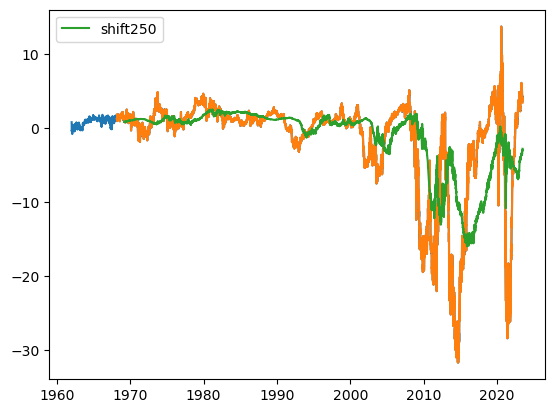

In [7]:
plt.plot(b0)
#plt.plot(endog)
plt.plot(b0f)
plt.plot(b0f_250.shift(250),label='shift250')
plt.legend()

In [8]:
b1,b1f,b1f_250=forecastARIMA(nforecasts = 1,X=X['b1'],order=(1,0,0))

init 1536
random walk rmse 0.08355486553472034
ar1 rmse         0.08588061097502686 1536
repeat 15360
random walk rmse          0.4445455205834841
ar1 rmse  in sample       0.44494804764773155
out of sample forecast 0.4677608202952118
random walk rmse 250          5.622205691240388
out of sample forecast 3.6910756647181002


In [9]:
b2,b2f,b2f_250=forecastARIMA(nforecasts = 1,X=X['b2'],order=(1,0,0))

init 1536
random walk rmse 0.1315385256782295
ar1 rmse         0.1395854691488248 1536
repeat 15360
random walk rmse          0.7561291465902658
ar1 rmse  in sample       0.757228160767064
out of sample forecast 0.7961510825115322
random walk rmse 250          10.357588050545386
out of sample forecast 6.6459057855585275


In [10]:
len(b0),len(b1),len(b2),len(b0f),len(b1f),len(b2f),len(b0f_250),len(b1f_250),len(b2f_250)

(15360, 15360, 15360, 13825, 13825, 13825, 13825, 13825, 13825)

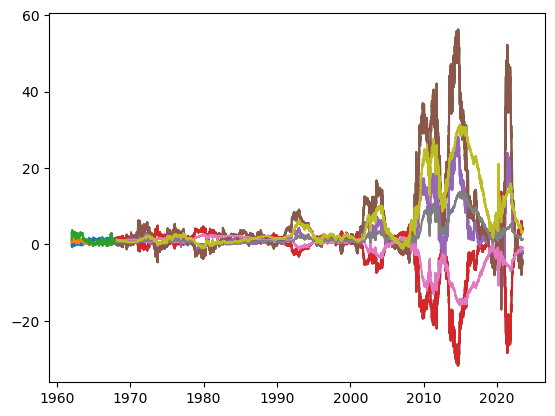

In [11]:
X = pd.DataFrame({'b0': b0.values.T[0], 'b1': b1.values.T[0], 'b2': b2.values.T[0]},index=X.index[-len(b0):])
plt.plot(X)
Xf = pd.DataFrame({'b0': b0f.values.T[0], 'b1': b1f.values.T[0], 'b2': b2f.values.T[0]},index=X.index[-len(b0f):])
plt.plot(Xf)
Xf250=pd.DataFrame({'b0': b0f_250.values.T[0], 'b1': b1f_250.values.T[0], 'b2': b2f_250.values.T[0]},index=X.index[-len(b0f_250):])
plt.plot(Xf250)
plt.show()

In [12]:
def NS2(endog,exog,fcst,fcst250):
    #endog=ty['1y']
    #exog=X[-len(endog):]
    #if not isinstance(endog.index, pd.PeriodIndex):
    #    endog.index = endog.index.to_period('D')  # ここでは日次データを仮定しています
    # Get the number of initial training observations
    da=[]
    fv=[]
    f = []
    f250=[]
    nobs = len(endog)
    n_init_training = len(endog)-len(fcst)
    nobs2=n_init_training
    # Create model for initial training sample, fit parameters
    training_endog = endog.iloc[:n_init_training]
    training_exog = exog.iloc[:n_init_training]
    mod = OLS(training_endog.values, sm.add_constant(training_exog.values))
    res = mod.fit()
    # Save initial forecast
    da.append(training_endog.index.date[0])
    fv=res.fittedvalues.tolist()
    f.append(res.predict(sm.add_constant(training_exog).values)[0])
    f250.append(res.predict(sm.add_constant(fcst250.iloc[:n_init_training]).values)[0])

    print('init',n_init_training, 'nobs',nobs)
    print('random walk rmse', training_endog.diff().var()**0.5)
    print('ar1 rmse        ',(np.mean(res.resid**2))**0.5,len(res.resid))

    for t in range(n_init_training, nobs):
        # Update the results by appending the next observation
        updated_endog = endog.iloc[t-nobs2:t+1]
        updated_exog  =  exog.iloc[t-nobs2:t+1]
        mod = OLS(updated_endog.values, sm.add_constant(updated_exog.values))
        res = mod.fit()
        # Save the new set of forecasts
        da.append(updated_endog.index.date[-1])
        fv.append(res.fittedvalues[-1])
        fX=fcst.values[t-nobs2]
        fX= np.hstack((1, fX))
        f.append(res.predict(fX)[0])
        fX250=fcst250.values[t-nobs2]
        fX250= np.hstack((1, fX250))
        f250.append(res.predict(fX250)[0])     
    fv=pd.DataFrame(fv,index=X.index)
    fc=pd.DataFrame(f,index=da)
    fc250=pd.DataFrame(f250,index=da)
    plt.plot(endog)
    plt.plot(fc,label="forecast")
    plt.plot(fc250.shift(250))
    plt.legend()
    #print(len(endog),len(f),len(f250),f)
    print('random walk rmse      ', endog.diff().var()**0.5)
    print('in sample             ',(np.mean((fv.values.T-endog.values.T)**2)**0.5,len(res.resid))[0])    
    print('out of sample         ',np.mean((fc.iloc[:-1].T.values-endog.iloc[-len(fc)+1:].T.values)**2)**0.5)
    print('random walk rmse 250  ', endog.diff(250).var()**0.5)
    print('out of sample         ',np.mean((fc250.iloc[:-1].T.values-endog.iloc[-len(fc250)+1:].T.values)**2)**0.5)

15360 15360 13825 13825
init 1535 nobs 15360
random walk rmse 0.025464481150693528
ar1 rmse         0.06976351152436255 1535
random walk rmse       0.08009707719319234
in sample              0.4361947616502947
out of sample          0.4626546156525185
random walk rmse 250   1.717228199612264
out of sample          1.5533740514502556


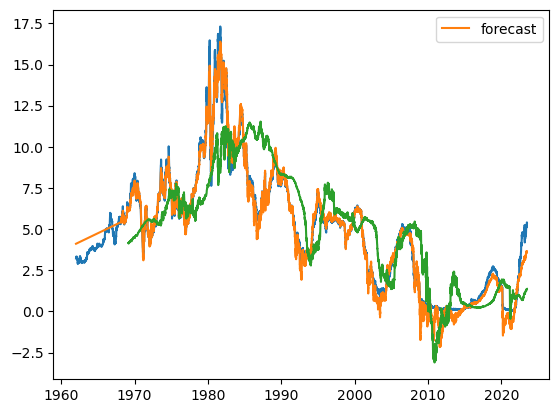

In [13]:
print(len(ty),len(X),len(Xf),len(Xf250))
ty0=ty['1y'].iloc[-len(X):]
NS2(endog=ty['1y'].iloc[-len(X):],exog=X,fcst=Xf,fcst250=Xf250)